In [783]:
from kbmodpy import kbmod as kb
from sklearn.cluster import DBSCAN
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [784]:
def add_trajectory(image_list, tr, psf):
    init_time = image_list[0].get_time()
    for i in image_list:
        t = i.get_time()-init_time
        #print('x: '+str(tr.x+tr.x_v*t) + ' y: ' + str(tr.y+tr.y_v*t) )
        i.add_object( tr.x+tr.x_v*t, tr.y+tr.y_v*t, tr.flux, psf )

In [785]:
def compare_trajectory(a, b, threshold):
    # compare flux too?
    return (a.x == b.x and a.y == b.y and 
    abs(a.x_v/b.x_v-1)<threshold and 
    abs(a.y_v/b.y_v-1)<threshold)

In [786]:
def match_trajectories(results_list, test_list, threshold):
    matches = []
    for r in results_list:
        if any(compare_trajectory(r, test, threshold) for test in test_list):
            matches.append(r)
    return matches

In [787]:
# adapted from analyzeImage.py
def cluster_trajectories( results, dbscan_args=None):

        """
        Use scikit-learn algorithm of density-based spatial clustering of
        applications with noise (DBSCAN)
        (http://scikit-learn.org/stable/modules/generated/
            sklearn.cluster.DBSCAN.html)
        to cluster the results of the likelihood image search using starting
        location, total velocity and slope of trajectory.

        Parameters
        ----------

        results: numpy recarray, required
        The results output from findObjects in searchImage.

        dbscan_args: dict, optional
        Additional arguments for the DBSCAN instance. See options in link
        above.

        Returns
        -------

        db_cluster: DBSCAN instance
        DBSCAN instance with clustering completed. To get cluster labels use
        db_cluster.labels_

        top_vals: list of integers
        The indices in the results array where the most likely object in each
        cluster is located.
        """

        default_dbscan_args = dict(eps=0.1, min_samples=1)

        if dbscan_args is not None:
            default_dbscan_args.update(dbscan_args)
        dbscan_args = default_dbscan_args

        slope_arr = []
        intercept_arr = []
        t0x_arr = []
        t0y_arr = []
        vel_total_arr = []
        vx_arr = []
        vel_x_arr = []
        vel_y_arr = []
        for r in results:
            t0x_arr.append(r.x)
            t0y_arr.append(r.y)
            vel_x_arr.append(r.x_v)
            vel_y_arr.append(r.y_v)

        db_cluster = DBSCAN(**dbscan_args)

        scaled_t0x = t0x_arr - np.min(t0x_arr)
        if np.max(scaled_t0x) > 0.:
            scaled_t0x = scaled_t0x/np.max(scaled_t0x)
        scaled_t0y = t0y_arr - np.min(t0y_arr)
        if np.max(scaled_t0y) > 0.:
            scaled_t0y = scaled_t0y/np.max(scaled_t0y)
        scaled_vx = vel_x_arr - np.min(vel_x_arr)
        if np.max(scaled_vx) > 0.:
            scaled_vx /= np.max(scaled_vx)
        scaled_vy = vel_y_arr - np.min(vel_y_arr)
        if np.max(scaled_vy) > 0.:
            scaled_vy /= np.max(scaled_vy)

        db_cluster.fit(np.array([scaled_t0x, scaled_t0y,
                                 scaled_vx, scaled_vy
                                ], dtype=np.float).T)

        top_vals = []
        for cluster_num in np.unique(db_cluster.labels_):
            cluster_vals = np.where(db_cluster.labels_ == cluster_num)[0]
            top_vals.append(cluster_vals[0])

        return db_cluster, top_vals

In [788]:
def calc_centers(t, timeArr):
    #ix, iy = zip(*[(t.x,t.y) for t in trajectories] )
    #xv, yv = zip(*[(t.x_v, t.y_v) for t in trajectories] )
    #startLocArr = np.array( [np.array(ix), np.array(iy)] )
    #velArr = np.array( [np.array(xv), np.array(yv)] )
    startLocArr = np.array( [t.x, t.y] )
    #print(startLocArr)
    velArr = np.array( [t.x_v, t.y_v] )
    centerArr = []
    for time in timeArr:
        centerArr.append(startLocArr + (velArr*time))
    return np.array(centerArr)

def create_postage_stamp(imageArray, traj,
                       timeArr, stamp_width):

    """
    Create postage stamp image coadds of potential objects traveling along
    a trajectory.
    Parameters
    ----------
    imageArray: numpy array, required
    The masked input images.
    objectStartArr: numpy array, required
    An array with the starting location of the object in pixels.
    velArr: numpy array, required
    The x,y velocity in pixels/hr. of the object trajectory.
    timeArr: numpy array, required
    The time in hours of each image starting from 0 at the first image.
    stamp_width: numpy array or list, [2], required
    The row, column dimensions of the desired output image.
    Returns
    -------
    stampImage: numpy array
    The coadded postage stamp.
    singleImagesArray: numpy array
    The postage stamps that were added together to create the coadd.
    """

    singleImagesArray = []
    stampWidth = np.array(stamp_width, dtype=int)
    #print stampWidth
    stampImage = np.zeros(stampWidth)

    #if len(np.shape(imageArray)) < 3:
    #    imageArray = [imageArray]

    measureCoords = calc_centers(traj, timeArr)
    #print(measureCoords)
    if len(np.shape(measureCoords)) < 2:
        measureCoords = [measureCoords]
    off_edge = []
    for centerCoords in measureCoords:
        #print((centerCoords[0] + stampWidth[0]/2 + 1) )
        #print( np.shape(imageArray[0])[1])
        if (centerCoords[0] + stampWidth[0]/2 + 1) > np.shape(imageArray[0])[1]:
            #raise ValueError('The boundaries of your postage stamp for one of the images go off the edge')
            off_edge.append(True)
        elif (centerCoords[0] - stampWidth[0]/2) < 0:
            #raise ValueError('The boundaries of your postage stamp for one of the images go off the edge')
            off_edge.append(True)
        elif (centerCoords[1] + stampWidth[1]/2 + 1) > np.shape(imageArray[0])[0]:
            #raise ValueError('The boundaries of your postage stamp for one of the images go off the edge')
            off_edge.append(True)
        elif (centerCoords[1] - stampWidth[1]/2) < 0:
            #raise ValueError('The boundaries of your postage stamp for one of the images go off the edge')
            off_edge.append(True)
        else:
            off_edge.append(False)

    i=0
    for image in imageArray:
        if off_edge[i] is False:
            xmin = int(np.rint(measureCoords[i,1]-stampWidth[0]/2))
            xmax = int(xmin + stampWidth[0])
            ymin = int(np.rint(measureCoords[i,0]-stampWidth[1]/2))
            ymax = int(ymin + stampWidth[1])
            #print xmin, xmax, ymin, ymax
            single_stamp = image[xmin:xmax, ymin:ymax]
            single_stamp[np.isnan(single_stamp)] = 0.
            single_stamp[np.isinf(single_stamp)] = 0.
            single_stamp[single_stamp < -9000.] = 0.
            if len(np.where(single_stamp == 0.)[0]) > 221.:
                singleImagesArray.append(single_stamp)
                continue
            stampImage += single_stamp
            singleImagesArray.append(single_stamp)
        else:
            single_stamp = np.zeros((stampWidth))
            singleImagesArray.append(single_stamp)

        i+=1
    return stampImage, singleImagesArray



In [789]:
path = '../../HITS/test_35/4,6tempExp/new_header/'

In [790]:
files = os.listdir(path)

In [791]:
files.sort()
files = [path+f for f in files]
files = files[:4]
files

['../../HITS/test_35/4,6tempExp/new_header/v410913-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v410969-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411019-fg.fits',
 '../../HITS/test_35/4,6tempExp/new_header/v411053-fg.fits']

In [792]:
images = [kb.layered_image(f) for f in files]

In [793]:
p = kb.psf(1.4)

In [794]:
object_count = 2000
x_range = (200,3650)
y_range = (200, 3650)
xv_range = (2100,2450)
yv_range = (800,1100)
angle_range = tuple( math.atan(yv/xv) for xv,yv in zip(xv_range, yv_range))
velocity_range = tuple( math.sqrt(xv**2+yv**2) for xv,yv in zip(xv_range, yv_range))
flux_range = (500, 6500)

In [795]:
results_key = []
for _ in range(object_count):
    traj = kb.trajectory()
    traj.x = int(rd.uniform(*x_range))
    traj.y = int(rd.uniform(*y_range))
    traj.x_v = rd.uniform(*xv_range)
    traj.y_v = rd.uniform(*yv_range)
    traj.flux = rd.uniform(*flux_range)
    results_key.append(traj)

In [796]:
results_key[0]

lh: 0.000000 flux: 1900.851685 x: 552 y: 808 x_v: 2265.444824 y_v: 995.012695 obs_count: 0

In [797]:
clustered = cluster_trajectories(results_key, dbscan_args=dict(eps=0.06, min_samples=1))
len(clustered[1])

1900

In [798]:
for t in results_key:
    add_trajectory(images, t, p)

In [799]:
len(match_trajectories(results_key, results_key, 0.05))

2000

In [800]:
stack = kb.image_stack(images)

In [801]:
flags = ~0 # mask pixels with any flags
flag_exceptions = [32,39] # unless it has one of these special combinations of flags
master_flags = int('100111', 2) # mask any pixels which have any of 
# these flags in more than two images

In [802]:
stack.apply_mask_flags(flags, flag_exceptions)

In [803]:
stack.apply_master_mask(master_flags, 2)

In [804]:
images = [i.science() for i in stack.get_images()]

In [805]:
img = images[1] #kb.layered_image("test",4096, 4096, 20.0, 400.0, 0.0)#

In [806]:
img = img[2700:3600,2900:3800]

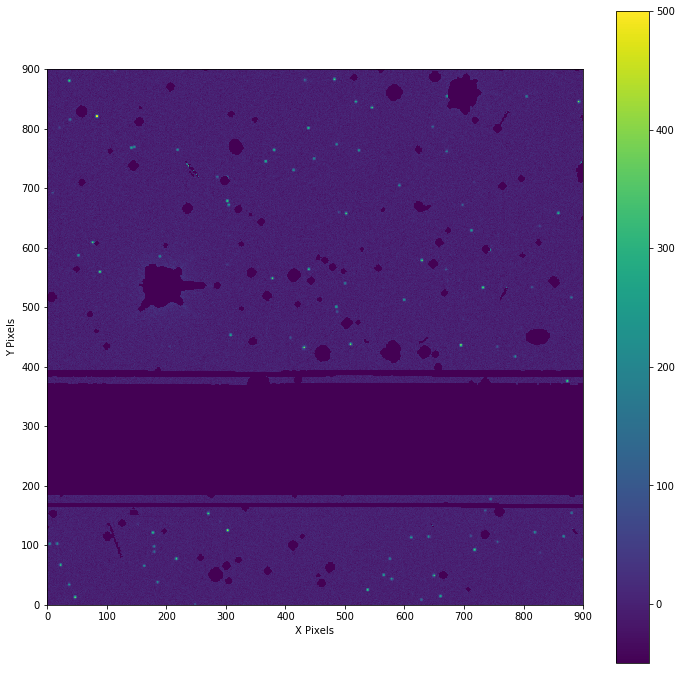

In [807]:
fig = plt.figure(figsize=(12,12))
plt.imshow(img, origin='lower',  vmin=-50, vmax=500)#cmap=plt.cm.Greys_r,
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()

In [808]:
search = kb.stack_search(stack, p)

In [809]:
search.gpu(80,80, *angle_range, *velocity_range)

In [810]:
search.filter_min_obs(3)

In [811]:
results = search.get_results(0, 1500000)

In [812]:
#results = [t for t in results if t.obs_count>=2]

In [813]:
len(results)

1500000

In [814]:
results_clustered = [ results[i] for i in cluster_trajectories(results, dbscan_args=dict(eps=0.018, min_samples=1))[1] ]

In [815]:
#search.save_results("filtered.txt", 0.01)

In [816]:
len(results_clustered)

2163

In [817]:
#results_clustered

In [818]:
#results_key

In [819]:
results_matched = match_trajectories(results_clustered, results_key, 0.01)
print(len(results_matched))
#matched_trajectories

491


In [820]:
results_to_plot = results_matched

In [821]:
stamps = [create_postage_stamp(images, t, stack.get_times(), [21,21])[0] for t in results_to_plot]

Starting at 0


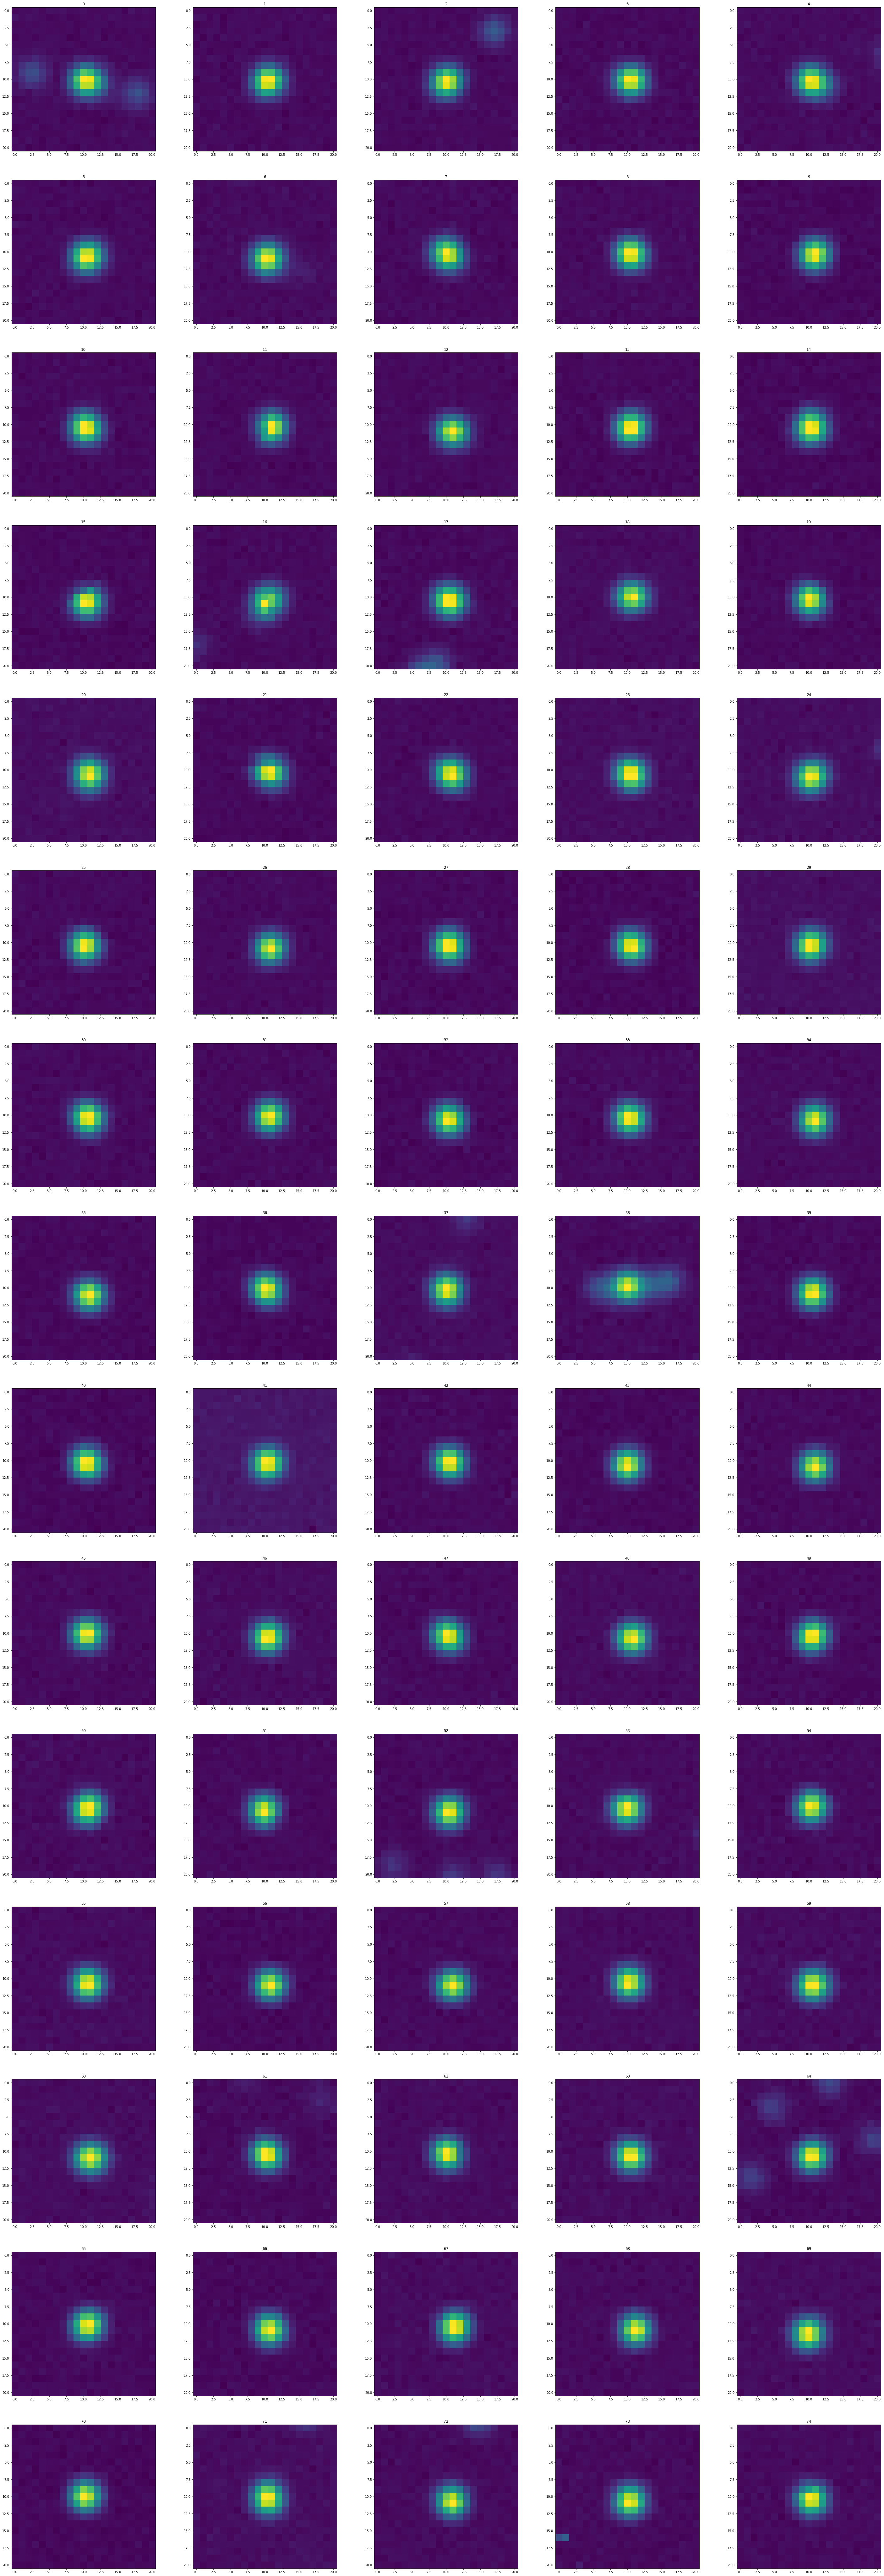

In [822]:
fig = plt.figure(figsize=(50, 150))
set_on = 1
plot_count = 75
print ('Starting at %i' % int((set_on - 1)*plot_count))
for i in range((set_on-1)*plot_count,set_on*plot_count):
    fig.add_subplot(15,5,i-(set_on-1)*plot_count+1)
    plt.imshow(stamps[i], #cmap=plt.cm.Greys_r, 
               interpolation=None)
    plt.title(str(i))

In [823]:
def plot_histogram(results_to_plt, bins, x_rng, y_rng, name, title, color):
# the histogram of the data
    n, bins, patches = plt.hist(np.array(results_to_plt), bins, normed=0, facecolor=color, alpha=0.75)

    # add a 'best fit' line
    #y = mlab.normpdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=1)

    plt.xlabel(name)
    plt.ylabel('Detections')
    plt.title(title)
    plt.axis([*x_rng, *y_rng])
    plt.grid(True)

    plt.show()

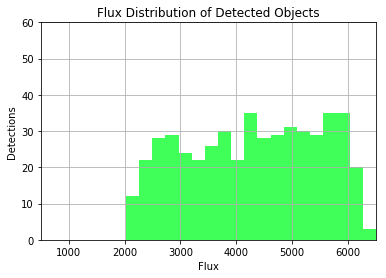

In [824]:
plot_histogram([t.flux for t in results_to_plot], 20, 
flux_range, (0,60), 'Flux', 'Flux Distribution of Detected Objects', '#00ff22')

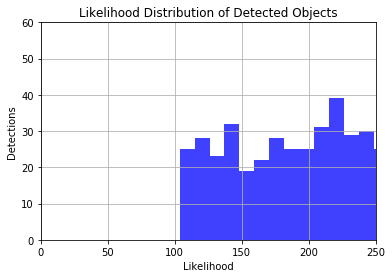

In [825]:
plot_histogram([t.lh for t in results_to_plot], 20, 
(0, 250), (0,60), 'Likelihood', 'Likelihood Distribution of Detected Objects', 'blue')

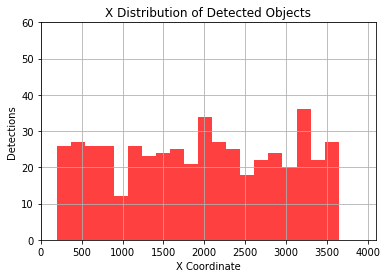

In [826]:
plot_histogram([t.x for t in results_to_plot], 20,
(0, 4096), (0,60), 'X Coordinate', 'X Distribution of Detected Objects', 'red')

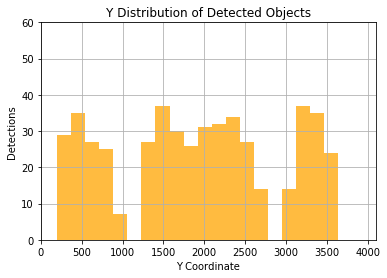

In [827]:
plot_histogram([t.y for t in results_to_plot], 20, 
(0, 4096), (0,60), 'Y Coordinate', 'Y Distribution of Detected Objects', 'orange')